### Objective  

**Using Random Forest before feature selection**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold 

pd.set_option('display.max_columns', None)

> retrieve data

In [2]:
categorical = pd.read_csv('cleaned_data/categorical.csv')
numerical = pd.read_csv('cleaned_data/numerical.csv')
target = pd.read_csv('cleaned_data/target.csv')

data = pd.concat([categorical, numerical, target], axis=1)
data

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,0,0.0
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1,0,0.0
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10

In [3]:
data['TARGET_B'].value_counts()

TARGET_B
0    90569
1     4843
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['TARGET_D', 'TARGET_B'])  # Features
y = data['TARGET_B']  # Target variable

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)

#SCALE
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on training numerical data
X_train_scaled_num = scaler.fit_transform(X_train_num)

# Transform the test numerical data using the same scaler
X_test_scaled_num = scaler.transform(X_test_num)

# Create DataFrames for scaled numerical data
X_train_scaled_num_df = pd.DataFrame(X_train_scaled_num, columns=X_train_num.columns)
X_test_scaled_num_df = pd.DataFrame(X_test_scaled_num, columns=X_test_num.columns)

# ENCODE
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train_cat)

# Transform the data using the fitted encoder
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=X_train_cat.columns)

X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=X_test_cat.columns)

# Concatenate the scaled numerical data with the encoded categorical data
X_train = pd.concat([X_train_scaled_num_df, X_train_cat_encoded_df], axis=1)
X_test = pd.concat([X_test_scaled_num_df, X_test_cat_encoded_df], axis=1)

> treat imbalance

In [7]:
data['TARGET_B'].value_counts()

TARGET_B
0    90569
1     4843
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
print(y_train.value_counts())

TARGET_B
0    72464
1    72464
Name: count, dtype: int64


0.8762281960697725
0.8348268092019074


TARGET_B
0    18105
1      978
Name: count, dtype: int64

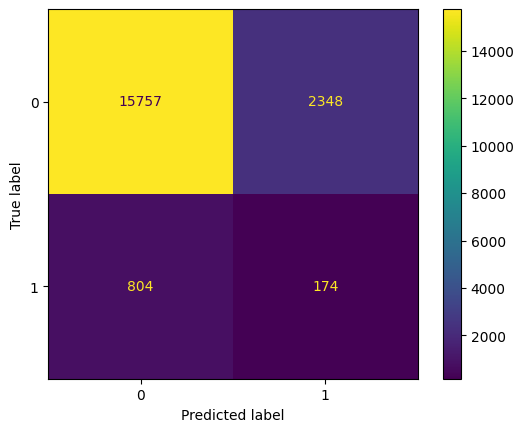

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

## select features based on variance

In [12]:
var_threshold = 0.02
sel = VarianceThreshold(threshold=var_threshold)

# Fit the VarianceThreshold selector only on the training data
sel.fit(X_train)

# Get the indices of the selected features
selected_indices_train = sel.get_support(indices=True)

# Get the selected column names for training data
selected_columns_train = X_train.columns[selected_indices_train]

# Transform both the training and test data using the same selector
X_var_train = pd.DataFrame(sel.transform(X_train), columns=selected_columns_train)
X_var_test = pd.DataFrame(sel.transform(X_test), columns=selected_columns_train)  # Use the same selected columns as training data

In [13]:
X_var_train

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,DOB_YR,DOB_MM,MINRDATE_MM,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_MM,INCOME,WEALTH1,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,DW1,DW2,DW4,DW5,DW6,HV1,HV2,HV3,HV4,HU1,HU2,HU5,HHD2,HHD3,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR2,HUPA2,HUPA6,RP1,RP2,RP3,RP4,MSA,ADI,HHAS3,MC1,MC2,PEC2,TPE13,LFC4,LFC6,LFC7,LFC8,LFC9,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC8,HC11,HC13,HC17,HC18,HC19,MHUC1,MHUC2,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,HOMEOWNR,GENDER,RFA_2A,GEOCODE2,DOMAIN_A
0,0.019231,1.0,0.000000,0.928571,0.000000,0.090909,0.090909,0.090909,0.500000,0.090909,0.090909,0.666667,1.000000,0.212121,1.000000,1.000000,0.000000,0.000000,0.888889,0.020202,0.313131,0.272727,0.686869,0.454545,0.313131,0.215667,0.226000,0.384615,0.384615,0.535354,0.474747,0.000000,0.666667,0.535354,0.080808,0.363636,0.757576,0.919192,1.000000,0.020202,0.464646,0.212121,0.242424,0.595960,0.838384,0.969697,1.000000,0.170940,0.078341,0.454545,0.464646,0.545455,0.010101,0.787879,0.545455,0.898990,0.848485,1.000000,0.000000,0.383838,0.575758,0.808081,0.343434,0.711538,0.000000,0.030303,0.070707,0.181818,0.828283,0.959596,0.020202,1.000000,0.000000,1.000000,0.285714,0.600000,0.472526,1.000000,0.000000,0.426230,3.000000,0.0,0.0,2.000000,0.000000,4.000000
1,0.192308,0.5,0.000000,0.500000,0.350515,0.000000,1.000000,0.909091,0.000000,0.727273,0.818182,0.500000,1.000000,0.282828,1.000000,0.000000,0.000000,1.000000,0.888889,0.010101,0.666667,0.656566,0.050505,0.050505,0.050505,0.080500,0.111500,0.153846,0.153846,0.838384,0.171717,0.555556,0.737374,0.646465,0.020202,0.090909,0.191919,0.292929,0.484848,0.010101,0.161616,0.050505,0.000000,0.030303,0.090909,0.212121,0.555556,0.000000,0.311828,0.424242,0.444444,0.565657,0.171717,0.626263,0.505051,0.555556,0.444444,0.525253,0.868687,0.535354,0.646465,0.878788,0.545455,0.326923,0.090909,0.272727,0.656566,0.979798,0.030303,0.010101,0.565657,0.787879,0.222222,0.101010,0.285714,0.400000,0.098807,0.000000,0.333333,0.950820,8.000000,0.0,0.0,2.000000,3.000000,2.000000
2,0.673077,1.0,0.333333,0.357143,0.360825,0.000000,0.000000,0.000000,0.500000,0.000000,0.727273,1.000000,0.666667,0.333333,1.000000,0.000000,0.636364,0.373737,0.959596,0.050505,0.808081,0.797980,0.141414,0.111111,0.080808,0.066000,0.075667,0.153846,0.153846,0.707071,0.303030,0.070707,0.737374,0.616162,0.000000,0.010101,0.040404,0.090909,0.272727,0.000000,0.464646,0.030303,0.090909,0.000000,0.010101,0.111111,0.565657,0.000000,0.321045,0.353535,0.454545,0.555556,0.060606,0.232323,0.727273,0.747475,0.595960,0.424242,0.000000,0.333333,0.868687,1.000000,0.545455,0.423077,0.070707,0.171717,0.444444,0.686869,0.323232,0.606061,0.282828,0.979798,0.020202,0.737374,0.428571,0.400000,0.307856,1.000000,0.333333,0.852459,11.000000,0.0,1.0,1.000000,3.000000,3.000000
3,0.384615,0.5,0.666667,0.357143,0.268041,0.000000,0.000000,0.909091,0.000000,0.454545,0.636364,0.166667,1.000000,0.303030,0.555556,1.000000,0.000000,0.000000,0.969697,0.010101,0.878788,0.868687,0.131313,0.090909,0.000000,0.121833,0.127167,0.307692,0.307692,0.838384,0.171717,0.131313,0.838384,0.696970,0.010101,0.010101,0.101010,0.464646,0.919192,0.000000,0.575758,0.000000,0.000000,0.202020,0.373737,0.858586,0.959596,0.547009,0.164363,0.343434,0.353535,0.656566,0.747475,0.717172,0.696970,0.838384,0.636364,1.000000,0.000000,0.303030,0.868687,0.969697,0.616162,0.750000,0.090909,0.191919,0.292929,0.292929,0.717172,0.797980,0.070707,0.949495,0.060606,0.949495,0.380952,0.400000,0.429001,1.000000,0.000000,0.344262,11.000000,0.0,1.0,1.000000,0.000000,2.000000
4,0.807692,0.5,0.333333,0.428571,0.000000,0.090909,0.818182,1.000000,0.000000,1.000000,0.818182,0.000000,1.000000,0.383838,0.222222,0.000000,0.000000,1.000000,0.898990,0.000000,0.515152,0.515152,0.010101,0.010101,0.010101,0.113167,0.119000,0.230769,0.230769,0.757576,0.252525,0.111111,0.858586,0.737374,0.000000,0.000000,0.131313,0.343434,0.828283,0.000000,0.414141,0.010101,0.010101,0.050505,0.191919,0.595960,0.686869,0.440171,0.6989

In [14]:
selected_columns = selected_columns_train.to_list()
len(selected_columns)

86

>redo to have scaler and encoder fits properly

In [33]:
X = data[selected_columns]
y = data['TARGET_B']

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)

#SCALE
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on training numerical data
X_train_scaled_num = scaler.fit_transform(X_train_num)

# Transform the test numerical data using the same scaler
X_test_scaled_num = scaler.transform(X_test_num)

# Create DataFrames for scaled numerical data
X_train_scaled_num_df = pd.DataFrame(X_train_scaled_num, columns=X_train_num.columns)
X_test_scaled_num_df = pd.DataFrame(X_test_scaled_num, columns=X_test_num.columns)

# ENCODE
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train_cat)

# Transform the data using the fitted encoder
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=X_train_cat.columns)

X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns=X_test_cat.columns)

# Concatenate the scaled numerical data with the encoded categorical data
X_train = pd.concat([X_train_scaled_num_df, X_train_cat_encoded_df], axis=1)
X_test = pd.concat([X_test_scaled_num_df, X_test_cat_encoded_df], axis=1)

In [36]:
# upsameple again
# from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train, y_train = smote.fit_resample(X_train, y_train)

0.8563217597703687
0.812870093800765


TARGET_B
0    18105
1      978
Name: count, dtype: int64

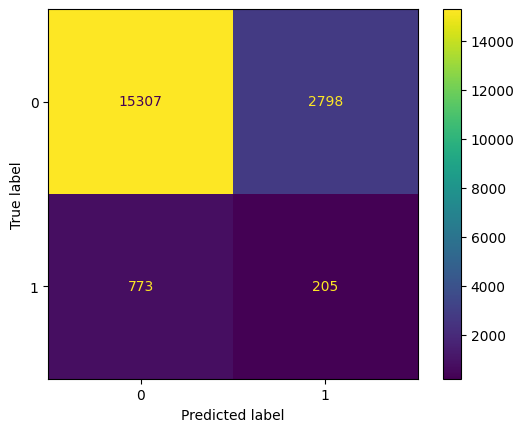

In [37]:
clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_var_test)
display(y_test.value_counts())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_display.plot()

In [ ]:
# from sklearn.model_selection import cross_val_score
# recall_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall_macro')

In [ ]:
# recall_scores

In [ ]:
# from sklearn.metrics import make_scorer, recall_score
# from scipy.stats import randint

# # Define the Random Forest classifier
# rf_classifier = RandomForestClassifier()
# from sklearn.model_selection import RandomizedSearchCV

# # Define the hyperparameter grid
# param_dist = {
#     'n_estimators': randint(50, 200),  # Number of trees in the forest
#     'max_depth': randint(5, 50),        # Maximum depth of the trees
#     'min_samples_split': randint(2, 20), # Minimum number of samples required to split a node
#     'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
#     'max_features': ['auto', 'sqrt'],   # Number of features to consider at each split
#     'bootstrap': [True, False]          # Whether bootstrap samples are used when building trees
# }

# # Define a custom scorer for recall
# scorer = make_scorer(recall_score)

# # Define RandomizedSearchCV with recall as the scoring metric
# random_search_recall = RandomizedSearchCV(estimator=rf_classifier, 
#                                           param_distributions=param_dist, 
#                                           n_iter=100,
#                                           cv=5,
#                                           scoring=scorer,  # Use recall as the scoring metric
#                                           random_state=42)

# # Perform the Randomized Search
# random_search_recall.fit(X_var_train, y_train)

# # Get the best parameters
# best_params_recall = random_search_recall.best_params_
# print("Best parameters for recall optimization:", best_params_recall)

# # Get the best model
# best_model_recall = random_search_recall.best_estimator_

# # Evaluate the best model on test data
# test_recall = recall_score(y_test, best_model_recall.predict(X_var_test))
# print("Test Recall:", test_recall)

In [46]:
# get full data
X_train_full = data[selected_columns]
y_train_full = data['TARGET_B']
X_train_full.head(1)

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,DOB_YR,DOB_MM,MINRDATE_MM,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_MM,INCOME,WEALTH1,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,DW1,DW2,DW4,DW5,DW6,HV1,HV2,HV3,HV4,HU1,HU2,HU5,HHD2,HHD3,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR2,HUPA2,HUPA6,RP1,RP2,RP3,RP4,MSA,ADI,HHAS3,MC1,MC2,PEC2,TPE13,LFC4,LFC6,LFC7,LFC8,LFC9,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC8,HC11,HC13,HC17,HC18,HC19,MHUC1,MHUC2,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,HOMEOWNR,GENDER,RFA_2A,GEOCODE2,DOMAIN_A
0,36,3,2,89,37,12,8,2,95,12,11,5,9,18,5,0,35,65,92,1,97,95,2,0,0,479,635,3,2,86,14,7,80,70,2,7,13,27,47,0,61,0,0,2,5,17,73,0.0,177.0,51,46,54,13,45,64,62,53,99,0,18,74,88,77,31,14,14,31,54,46,90,10,33,65,40,6,2,95515,0,4,39,IL,H,F,E,C,T


In [52]:
#scale and enocde
# Split the full dataset into numerical and categorical features
X_train_full_num = X_train_full.select_dtypes(include=np.number)
X_train_full_cat = X_train_full.select_dtypes(include='object')

# Scale numerical features
target_b_scaler = MinMaxScaler()
X_train_full_num_scaled = target_b_scaler.fit_transform(X_train_full_num)
X_train_full_num_scaled_df = pd.DataFrame(X_train_full_num_scaled, columns=X_train_full_num.columns)

# Encode categorical features
target_b_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
target_b_encoder.fit(X_train_full_cat)
X_train_full_cat_encoded = target_b_encoder.transform(X_train_full_cat)
X_train_full_cat_encoded_df = pd.DataFrame(X_train_full_cat_encoded, columns=X_train_full_cat.columns)

# Concatenate scaled numerical and encoded categorical features
X_train_full_processed = pd.concat([X_train_full_num_scaled_df, X_train_full_cat_encoded_df], axis=1)


In [57]:
# upsample
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train, y_train = smote.fit_resample(X_train_full_processed, y_train_full)

In [60]:
# tagert_b_model = RandomForestClassifier(**best_params_recall)  # Using the best parameters found
target_b_model = RandomForestClassifier()
# Train the final model on the full dataset
target_b_model.fit(X_train_full_processed, y_train_full)

RandomForestClassifier()

> use on data

In [110]:
categorical = pd.read_csv('cleaned_data/categorical.csv')
numerical = pd.read_csv('cleaned_data/numerical.csv')
target = pd.read_csv('cleaned_data/target.csv')

df_target_b = pd.concat([categorical, numerical], axis=1)
data_with_predictions = df_target_b.copy()
df_target_b

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10,23,21,35,44,22,6,2,63,9,9,19,

In [111]:
# Filter columns
df_target_b = df_target_b[selected_columns]

numerical_columns = df_target_b.select_dtypes(include=['number'])
categorical_columns = df_target_b.select_dtypes(include=['object', 'category'])

In [112]:

# Scale numerical columns
df_target_b_scaled = target_b_scaler.transform(numerical_columns)
df_target_b_scaled = pd.DataFrame(df_target_b_scaled, columns=numerical_columns.columns)

# Encode categorical columns
df_target_b_encoded= target_b_encoder.transform(categorical_columns)
df_target_b_encoded = pd.DataFrame(df_target_b_encoded, columns=categorical_columns.columns)

# Concatenate scaled numerical and encoded categorical columns
X_train_processed = pd.concat([df_target_b_scaled, df_target_b_encoded], axis=1)
X_train_processed

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,DOB_YR,DOB_MM,MINRDATE_MM,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_MM,INCOME,WEALTH1,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,ETH2,DW1,DW2,DW4,DW5,DW6,HV1,HV2,HV3,HV4,HU1,HU2,HU5,HHD2,HHD3,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR2,HUPA2,HUPA6,RP1,RP2,RP3,RP4,MSA,ADI,HHAS3,MC1,MC2,PEC2,TPE13,LFC4,LFC6,LFC7,LFC8,LFC9,VC3,POBC2,LSC1,VOC2,HC2,HC4,HC5,HC6,HC7,HC8,HC11,HC13,HC17,HC18,HC19,MHUC1,MHUC2,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE,HOMEOWNR,GENDER,RFA_2A,GEOCODE2,DOMAIN_A
0,0.673077,1.0,0.333333,0.428571,0.381443,1.000000,0.636364,0.090909,0.0,1.000000,0.909091,0.666667,1.000000,0.181818,0.555556,0.000000,0.353535,0.656566,0.929293,0.010101,0.979798,0.959596,0.020202,0.000000,0.000000,0.079833,0.105833,0.230769,0.153846,0.868687,0.141414,0.070707,0.808081,0.707071,0.020202,0.070707,0.131313,0.272727,0.474747,0.000000,0.616162,0.000000,0.000000,0.020202,0.050505,0.171717,0.737374,0.000000,0.271889,0.515152,0.464646,0.545455,0.131313,0.454545,0.646465,0.626263,0.535354,1.000000,0.000000,0.181818,0.747475,0.888889,0.777778,0.596154,0.141414,0.141414,0.313131,0.545455,0.464646,0.909091,0.101010,0.333333,0.656566,0.404040,0.285714,0.4,0.498045,0.0,1.000000,0.622951,3.0,0.0,0.0,1.0,2.0,3.0
1,0.250000,1.0,0.000000,0.785714,0.536082,0.090909,0.818182,1.000000,0.0,1.000000,0.818182,0.833333,1.000000,0.111111,1.000000,1.000000,0.000000,0.000000,0.676768,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.911333,0.869667,0.923077,0.769231,0.969697,0.040404,0.090909,0.949495,0.888889,0.979798,0.989899,0.989899,0.989899,1.000000,0.949495,0.838384,0.000000,0.000000,0.919192,0.919192,0.919192,0.949495,0.478632,0.019969,0.666667,0.565657,0.444444,0.020202,0.717172,0.818182,0.646465,0.575758,1.000000,1.000000,0.111111,0.393939,0.505051,0.929293,0.192308,0.262626,0.565657,0.979798,1.000000,0.000000,0.969697,0.040404,1.000000,0.000000,1.000000,0.952381,0.8,0.774510,0.0,0.333333,0.000000,0.0,0.0,1.0,3.0,0.0,2.0
2,0.807692,1.0,0.333333,0.500000,0.000000,0.090909,0.909091,0.545455,0.0,1.000000,0.000000,0.333333,0.111111,0.333333,0.111111,0.000000,0.020202,0.989899,0.969697,0.020202,0.696970,0.696970,0.060606,0.050505,0.030303,0.082833,0.091000,0.153846,0.076923,0.787879,0.222222,0.181818,0.767677,0.656566,0.000000,0.010101,0.060606,0.181818,0.505051,0.000000,0.363636,0.020202,0.030303,0.000000,0.020202,0.090909,0.444444,0.000000,0.431644,0.313131,0.383838,0.626263,0.212121,0.616162,0.707071,0.787879,0.626263,0.828283,1.000000,0.323232,0.848485,0.969697,0.656566,0.423077,0.121212,0.232323,0.505051,0.696970,0.313131,0.000000,0.353535,0.222222,0.777778,0.171717,0.428571,0.4,0.078617,1.0,1.000000,0.967213,7.0,1.0,1.0,1.0,2.0,1.0
3,0.826923,1.0,0.333333,0.285714,0.288660,0.000000,0.909091,0.909091,0.0,1.000000,0.090909,0.000000,0.444444,0.313131,0.000000,0.000000,0.080808,0.929293,0.616162,0.000000,0.858586,0.838384,0.040404,0.010101,0.000000,0.166667,0.210500,0.153846,0.076923,0.484848,0.525253,0.060606,0.737374,0.616162,0.101010,0.252525,0.505051,0.696970,0.929293,0.101010,0.424242,0.000000,0.000000,0.010101,0.080808,0.171717,0.343434,0.997863,0.102919,0.262626,0.464646,0.545455,0.171717,0.434343,0.686869,0.333333,0.313131,0.000000,1.000000,0.313131,0.676768,0.565657,0.434343,0.730769,0.101010,0.191919,0.393939,0.454545,0.555556,0.454545,0.171717,0.232323,0.777778,0.222222,0.761905,0.4,0.899764,1.0,1.000000,0.655738,0.0,1.0,0.0,1.0,2.0,1.0
4,0.288462,1.0,0.333333,0.214286,0.206186,0.000000,0.818182,0.000000,0.5,0.000000,0.181818,0.333333,0.222222,0.535354,1.000000,1.000000,0.000000,0.000000,0.020202,0.989899,1.000000,0.989899,0.000000,0.000000,0.000000,0.096000,0.099000,0.307692,0.230769,0.909091,0.101010,0.000000,0.828283,0.494949,0.000000,0.010101,0.020202,0.161616,0.676768,0.000000,0.454545,0.000000,0.000000,0.252525,0.585859,0.747475,0.838384,0.534188,0.195084,0.111111,0.202020,0.808081,0.010101,0.767677,0.656566,0.808081,0.313131,0.818182,1.000000,0.535354,0.656566,1.000000,0.454545,0.653846,0.010101,

In [113]:
# Make predictions on the training data
predictions = target_b_model.predict(X_train_processed)

# Add predictions as a new column to the original DataFrame
data_with_predictions = pd.concat([data_with_predictions, target], axis=1)
data_with_predictions['TARGET_B_PRED'] = predictions

In [114]:
data_with_predictions

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D,TARGET_B_PRED
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,0,0.0,0
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1,0,0.0,0
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15

In [115]:
from sklearn.metrics import accuracy_score

# Assuming data_with_predictions['TARGET_B_PRED'] contains the predicted values
predicted_values = data_with_predictions['TARGET_B_PRED']

# Assuming TARGET_B contains the actual target values
actual_values = data_with_predictions['TARGET_B']

# Calculate accuracy
accuracy = accuracy_score(actual_values, predicted_values)

print("Accuracy:", accuracy)

Accuracy: 0.9999161531044313


In [116]:
data_with_predictions.to_csv('data_with_predictions.csv', index=False)

In [ ]:
# # Load the saved model from the file
# with open('final_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)